In [1]:
import pandas as pd
import numpy as np
import gc

# sklearn libs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
import xgboost as xgb


# logging and loading libs
from logging import StreamHandler, DEBUG, Formatter, FileHandler, getLogger
from load_data import load_test_data, load_train_data

DIR = 'result_tmp/'
logger = getLogger(__name__)

def gini(y, pred):
    fpr, tpr, thr = roc_curve(y, pred, pos_label=1)
    # in short, maximizing AUC also maximizes gini
    g = 2 * auc(fpr, tpr) - 1
    



log_fmt = Formatter('%(asctime)s %(name)s %(lineno)d [%(levelname)s][%(funcName)s] %(message)s ')
handler = StreamHandler()
handler.setLevel('INFO')
handler.setFormatter(log_fmt)
logger.addHandler(handler)

handler = FileHandler(DIR + 'train.py.log', 'a')
handler.setLevel(DEBUG)
handler.setFormatter(log_fmt)
logger.setLevel(DEBUG)
logger.addHandler(handler)

logger.info('start')

df = load_train_data()
x_train = df.drop(['target'], axis = 1)
y_train = df['target']

use_cols = x_train.columns.values

logger.debug('train columns: {} {}'.format(use_cols.shape, use_cols))

logger.info('Data prep ended {}'.format(x_train.shape))

2018-05-25 13:52:43,042 __main__ 39 [INFO][<module>] start 
2018-05-25 13:52:50,489 __main__ 49 [INFO][<module>] Data prep ended (595212, 58) 


In [2]:
who

DEBUG	 DIR	 FileHandler	 Formatter	 GridSearchCV	 LogisticRegression	 StratifiedKFold	 StreamHandler	 auc	 
df	 gc	 getLogger	 gini	 handler	 load_test_data	 load_train_data	 log_fmt	 log_loss	 
logger	 np	 pd	 roc_auc_score	 roc_curve	 use_cols	 x_train	 xgb	 y_train	 



In [4]:
x_train.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
1,9,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
2,13,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
3,16,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [7]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [8]:
import xgboost as xgb

In [9]:
d_train = xgb.DMatrix(x_train, label=y_train)

In [18]:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.3085,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'num_parallel_tree': 1,
    'min_child_weight': 4.2922,
    'eval_metric': 'auc',
    'eta':0.1,
    'gamma': 0.5290,
    'subsample':0.9930,
    'max_delta_step':0,
    'booster':'gbtree',
    'nrounds': 1001
}

In [19]:
xgb_cv_res = xgb.cv(xgb_params, d_train, num_boost_round=100, nfold=5, seed = 0, stratified=True,
             early_stopping_rounds=25, verbose_eval=10, show_stdv=False)

[0]	train-auc:0.588456	test-auc:0.583634
[10]	train-auc:0.632659	test-auc:0.624291
[20]	train-auc:0.635272	test-auc:0.625547
[30]	train-auc:0.638009	test-auc:0.627133
[40]	train-auc:0.640355	test-auc:0.627777
[50]	train-auc:0.642319	test-auc:0.628155
[60]	train-auc:0.644047	test-auc:0.628569
[70]	train-auc:0.645792	test-auc:0.628782
[80]	train-auc:0.64765	test-auc:0.629032
[90]	train-auc:0.649519	test-auc:0.629577
[99]	train-auc:0.650646	test-auc:0.629671


/home/jasonchan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


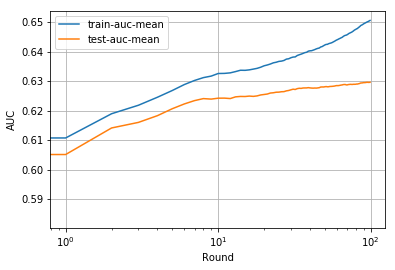

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline  

xgb_cv_res.plot(y=['train-auc-mean', 'test-auc-mean'],grid=True, logx=True)
plt.xlabel('Round')
plt.ylabel('AUC')
plt.savefig('performance.png', dpi = 200, bbox_inches='tight')
plt.show()




In [54]:
best_nrounds = xgb_cv_res.shape[0] - 1
xgb_best = xgb.train(xgb_params, d_train, best_nrounds)

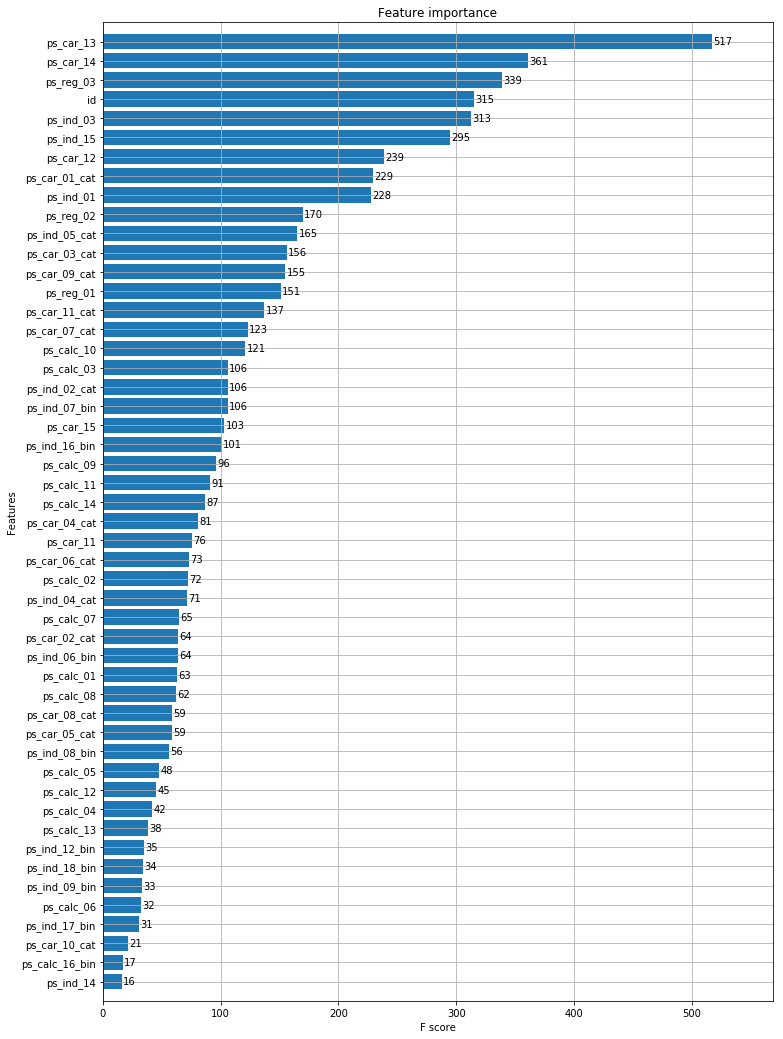

In [46]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_best, max_num_features=50, height=0.8, ax=ax)
plt.savefig('importance.png', bbox_inches='tight')
plt.show()



In [55]:
df = load_test_data()
x_test = df[use_cols].sort_values('id')

x_test = xgb.DMatrix(x_test)
pred_test = xgb_best.predict(x_test)

In [71]:
y_train.value_counts()[0] / y_train.value_counts()[1] 

26.43671061122891